# CallMeMaybe Operator Inefficiency Analysis

## Project Description

CallMeMaybe, a virtual telephony service, needs to identify its least effective operators. An operator is deemed **inefficient** if they exhibit:

- A high number of missed incoming calls (both internal and external).  
- Long average wait times for incoming calls.  
- (If applicable) A low volume of outgoing calls.

This repository provides:

1. **Exploratory Data Analysis** of call logs to surface usage patterns.  
2. **Identification** of inefficient operators based on key metrics.  
3. **Statistical Testing** (hypothesis tests) to confirm whether observed inefficiencies are significant.

---

### Dataset Description

The compressed dataset `telecom_dataset_us.csv` contains the following columns:

- `user_id`: Customer account ID  
- `date`: Date when the call statistics were retrieved  
- `direction`: Call direction (`out` for outgoing, `in` for incoming)  
- `internal`: Whether the call was internal (i.e., between operators of the same client)  
- `operator_id`: Identifier of the operator  
- `is_missed_call`: Indicates whether the call was missed  
- `calls_count`: Number of calls  
- `call_duration`: Duration of the call (excluding wait time)  
- `total_call_duration`: Total duration of the call (including wait time)  


The dataset `telecom_clients_us.csv` contains the following columns:

- `user_id`: Customer ID  
- `tariff_plan`: Current tariff plan of the customer  
- `date_start`: Date the customer registered  

---

## Objectives

1. **Explore** call volume, drop rates, and wait times per operator.  
2. **Compute** performance metrics:
   - Missed incoming call rate  
   - Average wait time  
   - Outgoing call count  
3. **Rank** operators by inefficiency and flag those below performance thresholds.  
4. **Perform** statistical tests (e.g., chi‑square, t‑tests) to validate whether inefficiency differences are statistically significant.

---

**Specify details** <br>
Definition of “ineffectiveness”: <br>
<ul>
What specific thresholds for dropped calls and hold time are considered “high volume”? <br>
How do we weight inbound vs. internal vs. outbound calls? <br>
What time window do we evaluate (daily, weekly, monthly)? <br>
</ul>
Scope of data:
<ul>
Do we exclude operators with fewer than X total calls? <br>
Do we only consider active accounts within a minimum period? <br>
</ul>

**Tableau Dashboard**

https://public.tableau.com/views/Book1_17484530567970/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## 1. Initial Data Loading and Exploration

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Read Datasets

In [2]:
df = pd.read_csv('datasets/telecom_dataset_us.csv')
df_clients = pd.read_csv('datasets/telecom_clients_us.csv')

In [3]:
print(df.shape)
print(df.info())
display(df.head())

(53902, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
print(df_clients.shape)
print(df_clients.info())
display(df_clients.head())

(732, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


## 2. Data Cleaning and Preparation

Check for null and duplicate data <br>
Impute, delete, or retain.

In [5]:
print(df.isnull().sum())
print(df.duplicated().sum())

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
4900


There are several missing values in operator_id and a few in internal. <br>
There are 4,900 duplicates.

In [6]:
#delete duplicates
df = df.drop_duplicates()
#fill missing values
df['operator_id'] = df['operator_id'].fillna(-1)
#assume missing is external calls
df['internal'] = df['internal'].fillna(False)
#check
print(df.isnull().sum())
print(df.duplicated().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64
0


/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_82065/341211105.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['internal'] = df['internal'].fillna(False)


In [7]:
#verify null values in df_clients
print(df_clients.isnull().sum())
print(df_clients.duplicated().sum())

user_id        0
tariff_plan    0
date_start     0
dtype: int64
0


Data conversion

In [8]:
#convertr float to int
df['operator_id'] = df['operator_id'].astype(int)
#convert date to to_datetime
df['date']= pd.to_datetime(df['date'])
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [9]:
#extract date because we don't need time
df['date'] = df['date'].dt.date
display(df)


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10,out,True,957922,False,1,0,25
53897,168606,2019-11-10,out,True,957922,True,1,0,38
53898,168606,2019-11-11,out,True,957922,False,2,479,501
53899,168606,2019-11-15,out,True,957922,False,4,3130,3190


In [10]:
#add columns
df['wait_time'] = df['total_call_duration'] - df['call_duration']

In [11]:
#merge dataframes to have plan information
df_plan = pd.merge(df,
                df_clients,
                on='user_id',
                how='left')
df_plan

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait_time,tariff_plan,date_start
0,166377,2019-08-04,in,False,-1,True,2,0,4,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...
48997,168606,2019-11-10,out,True,957922,False,1,0,25,25,C,2019-10-31
48998,168606,2019-11-10,out,True,957922,True,1,0,38,38,C,2019-10-31
48999,168606,2019-11-11,out,True,957922,False,2,479,501,22,C,2019-10-31
49000,168606,2019-11-15,out,True,957922,False,4,3130,3190,60,C,2019-10-31


## 3. Exploratory Data Analysis (EDA)

In [12]:
df.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,wait_time
count,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,777067.674911,16.462777,866.282091,1156.558202,290.276111
std,598.558965,329774.097101,63.604098,3775.503352,4451.473661,1132.155291
min,166377.000000,-1.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,890416.000000,1.000000,0.000000,46.000000,17.000000
50%,167158.000000,906406.000000,4.000000,37.000000,208.000000,55.000000
75%,167819.000000,929884.000000,12.000000,570.000000,901.000000,200.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000,46474.000000


In [13]:
# flags for call type
df['in_call']   = np.where(df['direction']=='in', df['calls_count'], 0)
df['out_call']  = np.where(df['direction']=='out', df['calls_count'], 0)
df['missed_in'] = np.where(
    (df['direction'] == 'in') & (df['is_missed_call']),
    1, 0
)

# incoming call duration 
df['in_total_duration'] = np.where(
    df['direction'] == 'in',
    df['total_call_duration'],
    0
)
df['in_calls_count'] = np.where(
    df['direction'] == 'in',
    df['calls_count'],
    0
)

# wait time calculation
df['wait_time'] = np.where(
    df['direction'] == 'in',
    df['total_call_duration'] - df['call_duration'],
    0
)
# discard erroneous values
df = df[df['wait_time'] >= 0]

# filter valid operators
df_ops = df[df['operator_id'] != -1]

# group and calculate metrics
operator_stats = (
    df_ops
    .groupby('operator_id')
    .agg(
        total_calls        = ('calls_count',       'sum'),
        total_in_calls     = ('in_call',           'sum'),
        total_out_calls    = ('out_call',          'sum'),
        missed_in_calls    = ('missed_in',         'sum'),
        total_in_duration  = ('in_total_duration', 'sum'),
        total_wait_time    = ('wait_time',         'sum')
    )
)

# derived metrics
# average incoming call duration
operator_stats['avg_in_duration'] = (
    operator_stats['total_in_duration'] / operator_stats['total_in_calls']
).replace([np.inf, np.nan], 0)

# missed incoming call rate
operator_stats['missed_in_rate'] = (
    operator_stats['missed_in_calls'] / operator_stats['total_in_calls']
).fillna(0)

# average wait time for incoming calls
operator_stats['avg_wait_time'] = (
    operator_stats['total_wait_time'] / operator_stats['total_in_calls']
).replace([np.inf, np.nan], 0)

display(operator_stats)

,total_calls,total_in_calls,total_out_calls,missed_in_calls,total_in_duration,total_wait_time,avg_in_duration,missed_in_rate,avg_wait_time
operator_id,,,,,,,,,
879896,930,58,872,0,6190,574,106.724138,0.0,9.896552
879898,7313,104,7209,0,8033,1680,77.240385,0.0,16.153846
880020,45,7,38,0,353,54,50.428571,0.0,7.714286
880022,197,8,189,0,624,112,78.000000,0.0,14.000000
880026,2232,24,2208,0,1730,143,72.083333,0.0,5.958333
...,...,...,...,...,...,...,...,...,...
972410,77,0,77,0,0,0,0.000000,0.0,0.000000
972412,61,1,60,0,145,25,145.000000,0.0,25.000000
972460,51,1,50,0,18,4,18.000000,0.0,4.000000


Distribución del número total de llamadas.

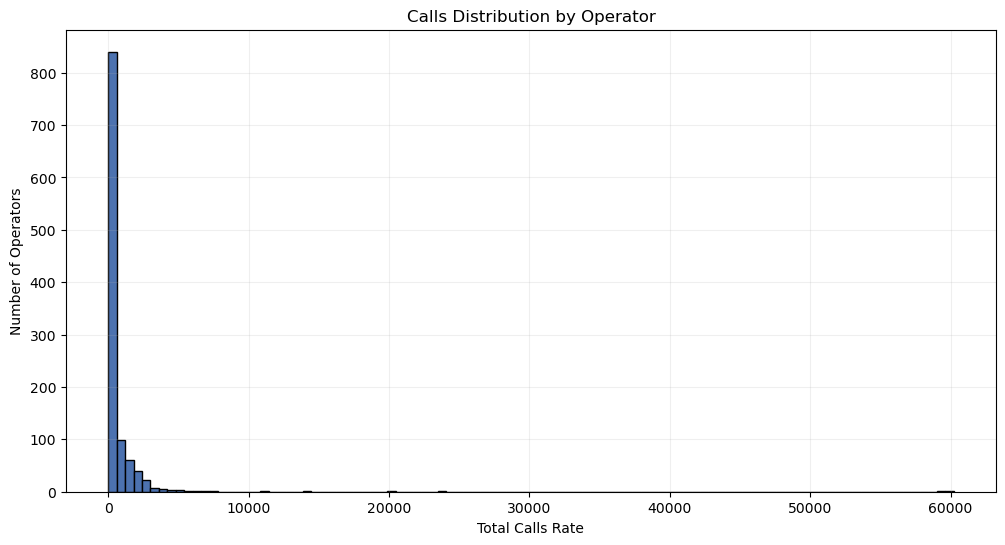

In [14]:
operator_stats['total_calls'].plot(kind='hist',
                           figsize=(12,6),
                           bins=100,
                           title='Calls Distribution by Operator',
                           color= '#4C72B0',
                            edgecolor='black'
                          )

plt.xlabel('Total Calls Rate')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

In [15]:
# percentiles calculation
q10 = operator_stats['total_calls'].quantile(0.10)
q25 = operator_stats['total_calls'].quantile(0.25)
print(f"p10 = {q10:.0f}, p25 = {q25:.0f}")

p10 = 3, p25 = 10


The percetil10 = 3 calls is used to filter the data frame:
<ul>
– With fewer than 4 calls, the missed call rate is very unstable, with a huge margin of error. <br>
– By cutting at p10 = 3, you are left with the 90% of operators who have a minimum volume that guarantees a more reliable result.
</ul>

In [16]:
#filter operators with more than 3 calls (percetil10)
operator_stats = operator_stats[operator_stats['total_calls'] > 3 ]

Distribution of the rate of missed incoming calls

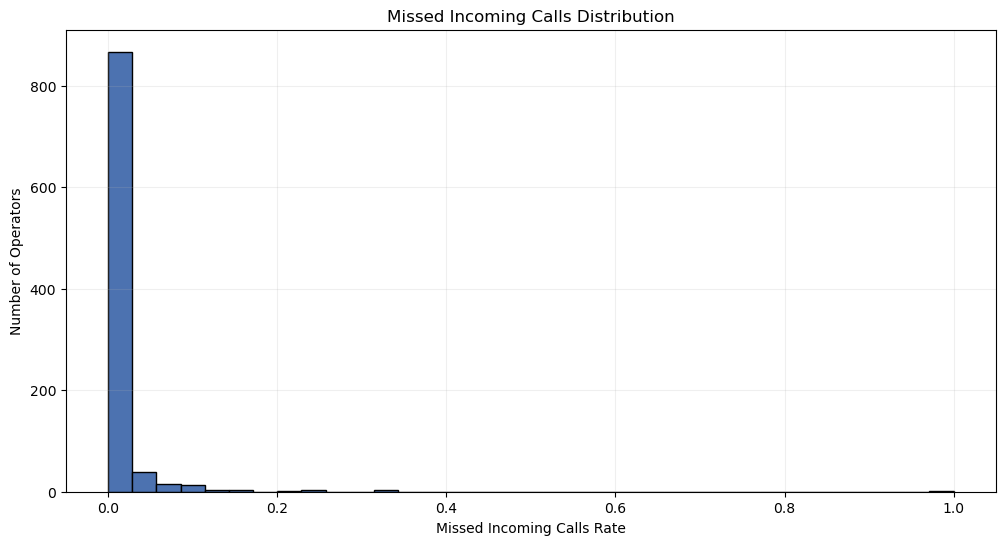

In [17]:
operator_stats['missed_in_rate'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Missed Incoming Calls Distribution',
                           color= '#4C72B0',
                           edgecolor='black'
                          )
plt.xlabel('Missed Incoming Calls Rate')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

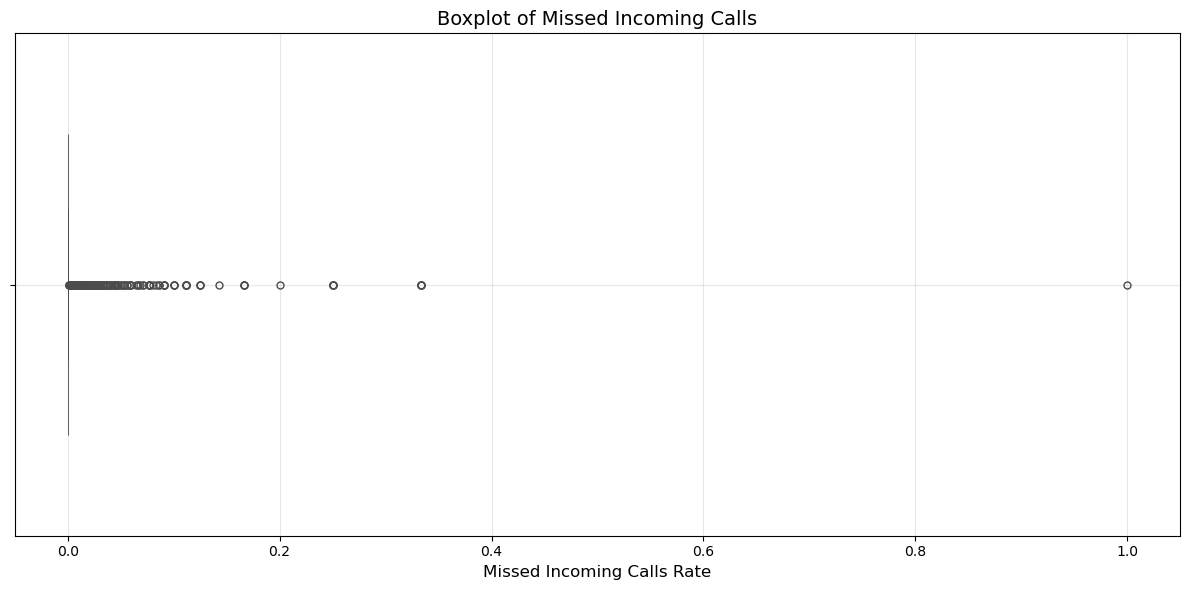

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['missed_in_rate'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=0.5,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Missed Incoming Calls Rate', fontsize=12)
plt.title('Boxplot of Missed Incoming Calls', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Most operators are close to 0, which means they have almost no missed calls and for the other side we have one operator with 1 missed incoming calls rate, that means that this operator lost all the calls

Out calls distribution

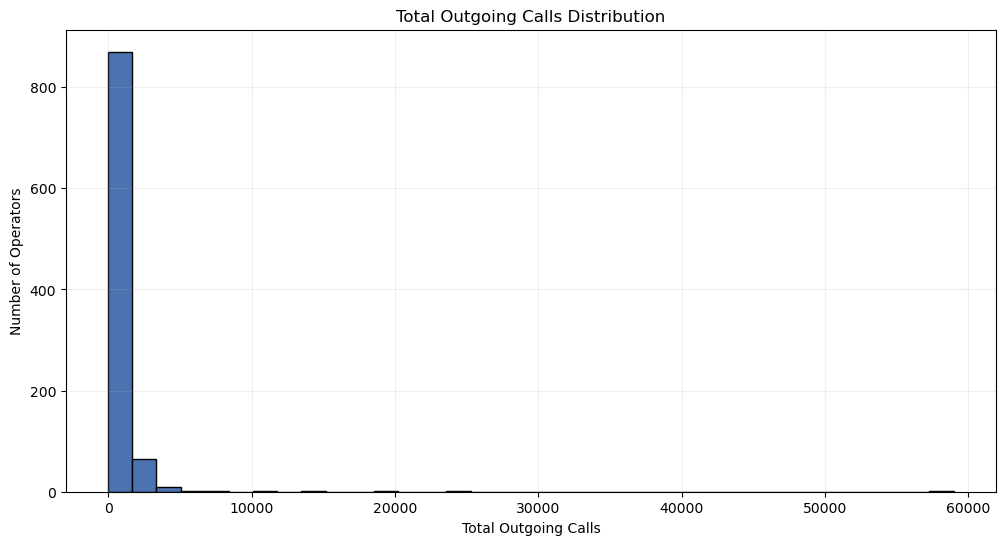

In [19]:
# Histogram
operator_stats['total_out_calls'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Total Outgoing Calls Distribution',
                           color= '#4C72B0',
                            edgecolor='black'
                          )
plt.xlabel('Total Outgoing Calls')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

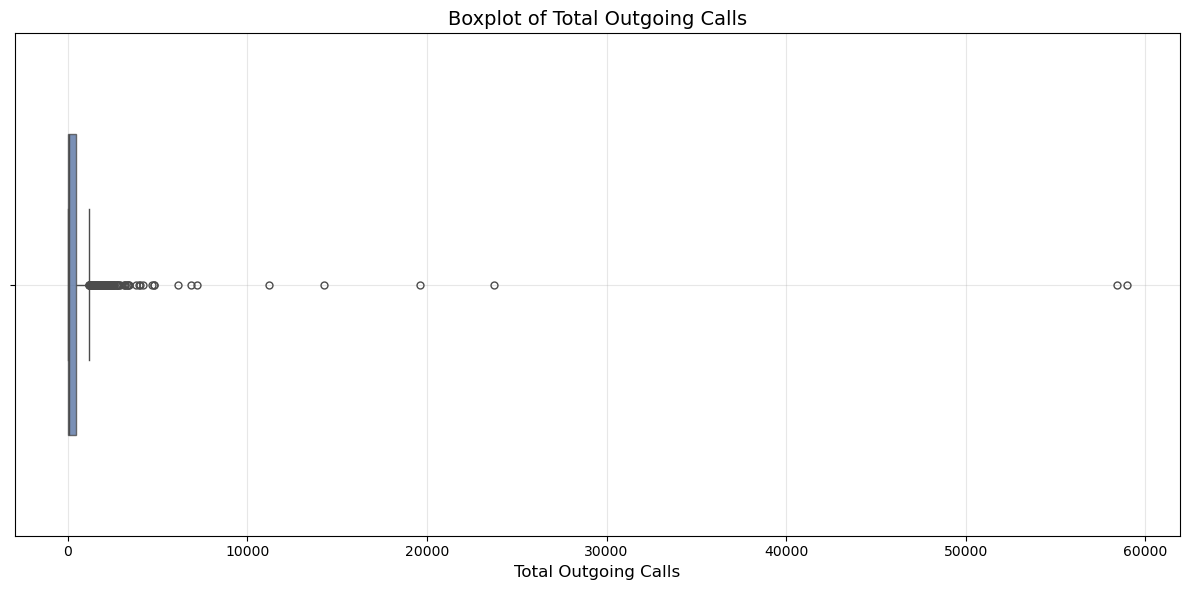

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['total_out_calls'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Total Outgoing Calls', fontsize=12)
plt.title('Boxplot of Total Outgoing Calls', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

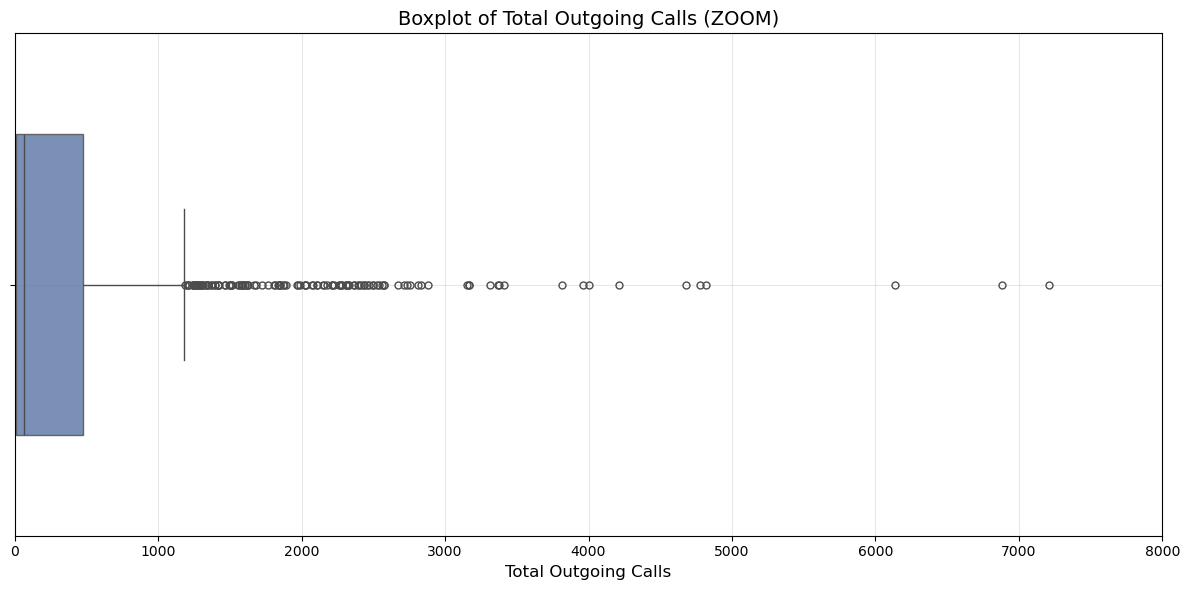

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['total_out_calls'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)
plt.xlim(0,8000)
plt.xlabel('Total Outgoing Calls', fontsize=12)
plt.title('Boxplot of Total Outgoing Calls (ZOOM)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

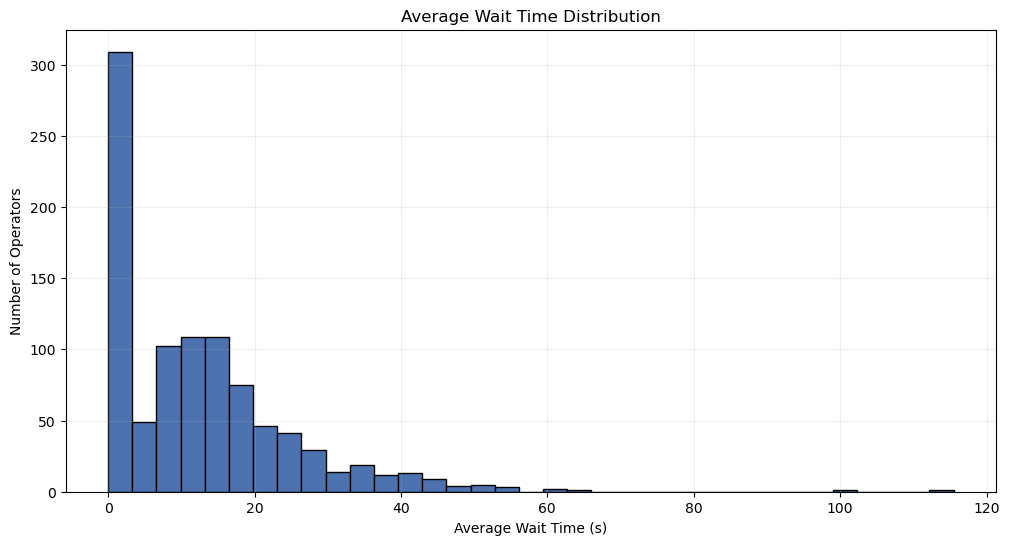

In [22]:
# Histogram of average wait time
operator_stats['avg_wait_time'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Average Wait Time Distribution',
                           color= '#4C72B0',
                            edgecolor='black'
                          )
plt.xlabel('Average Wait Time (s)')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

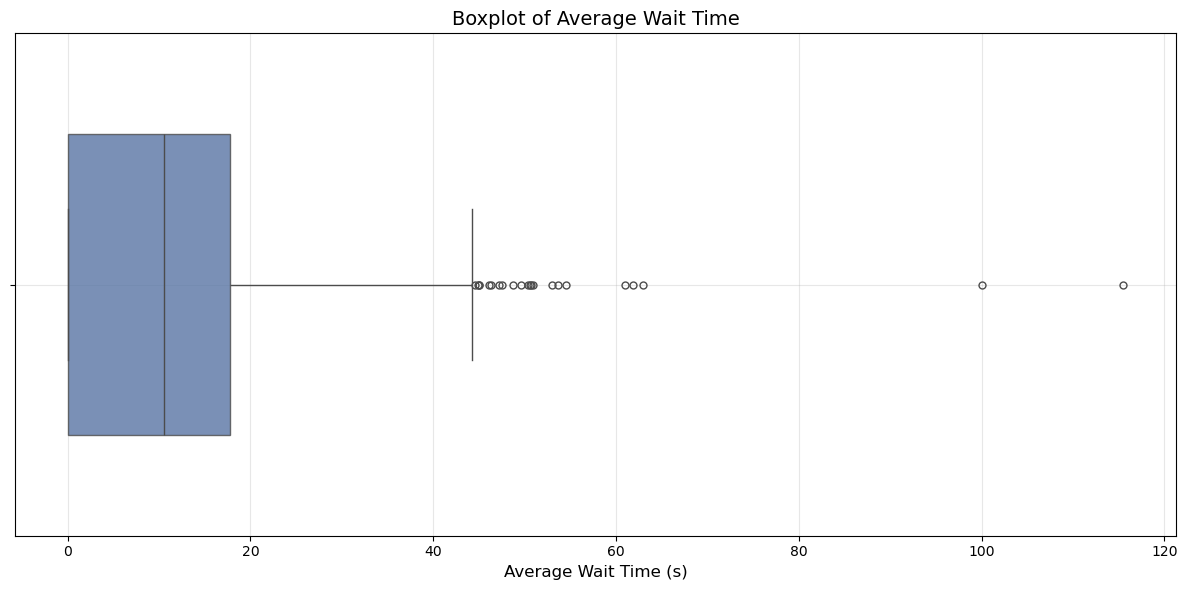

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['avg_wait_time'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=1,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Average Wait Time (s)', fontsize=12)
plt.title('Boxplot of Average Wait Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Distribution of average call duration

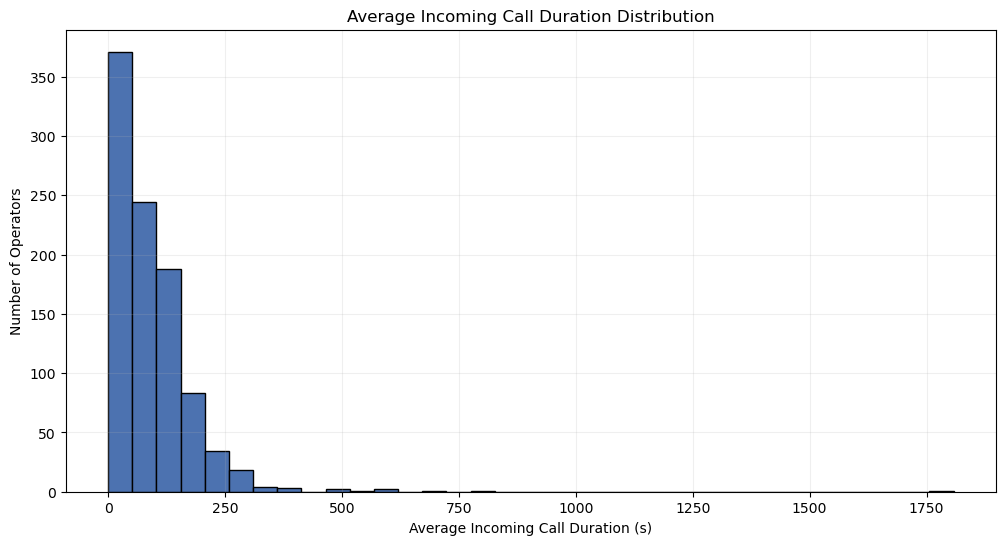

In [24]:
operator_stats['avg_in_duration'].plot(kind='hist',
                           figsize=(12,6),
                           bins=35,
                           title='Average Incoming Call Duration Distribution',
                           color= '#4C72B0',
                           edgecolor='black'
                          )
plt.xlabel('Average Incoming Call Duration (s)')
plt.ylabel('Number of Operators')
plt.grid(True, alpha=0.2)
plt.show()

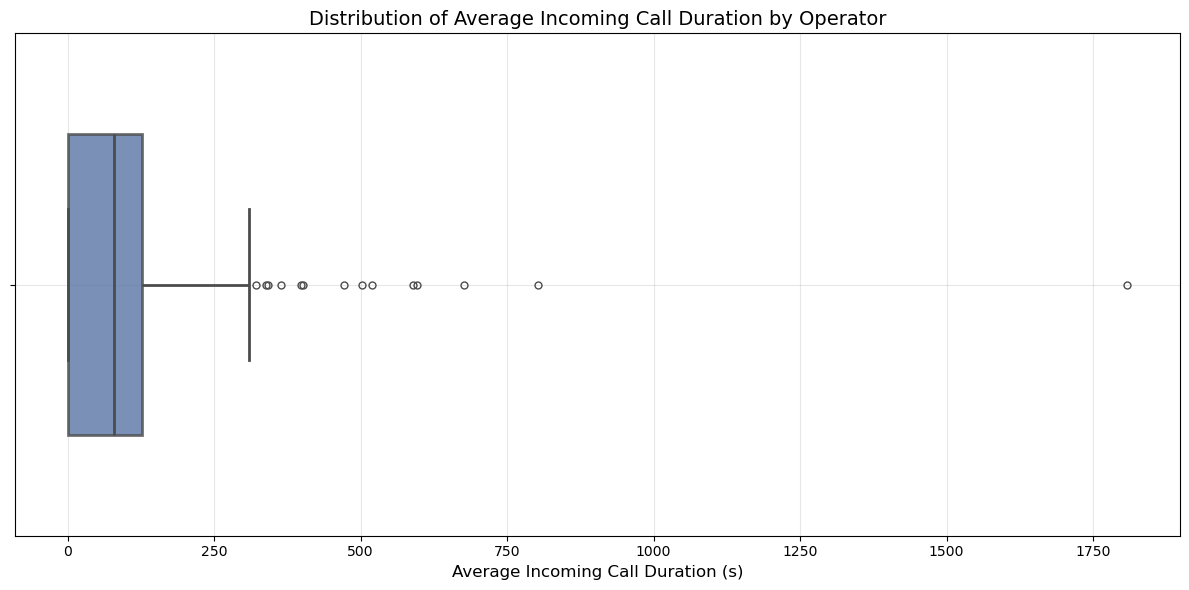

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=operator_stats['avg_in_duration'],
    color='#4C72B0',              
    width=0.6,                    
    fliersize=5,                  
    linewidth=2,                  
    boxprops=dict(alpha=0.8),    
)

plt.xlabel('Average Incoming Call Duration (s)', fontsize=12)
plt.title('Distribution of Average Incoming Call Duration by Operator', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

Most call durations range between 100 and 400 seconds; however, there are also calls that exceed 500 seconds.

Relationship between missed call rate and average call duration

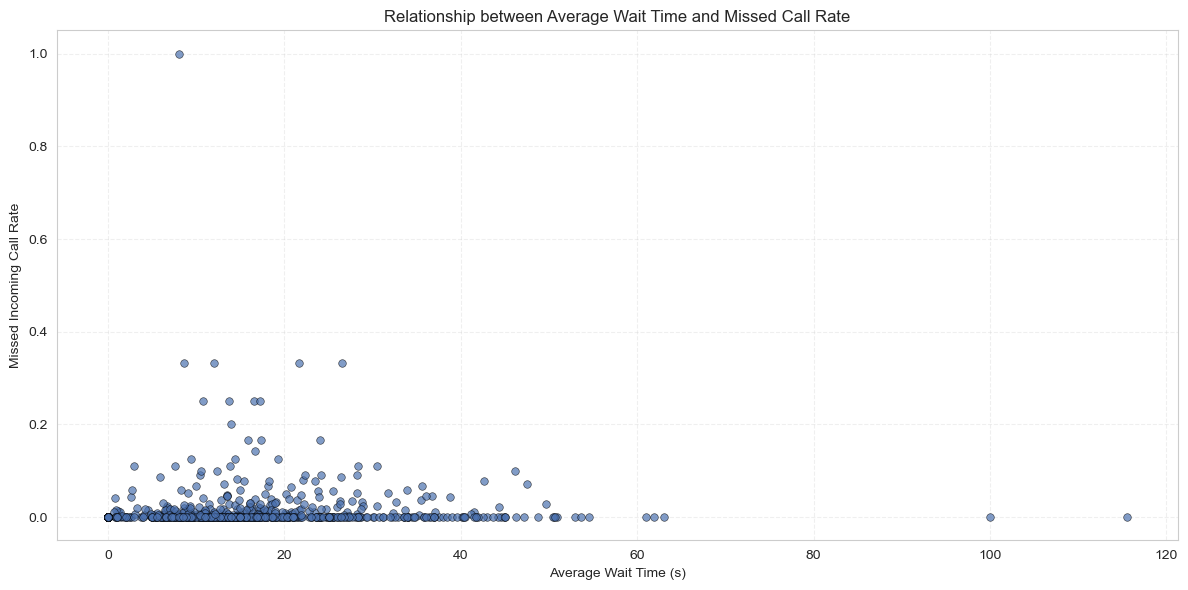

In [26]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='avg_wait_time',
    y='missed_in_rate',
    data=operator_stats,
    color='#4C72B0',
    s=30,                   
    alpha=0.7,              
    edgecolor='black'      
)



# Personalización
plt.xlabel('Average Wait Time (s)',fontsize=10)
plt.ylabel('Missed Incoming Call Rate', fontsize=10)
plt.title('Relationship between Average Wait Time and Missed Call Rate')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

<ul>
If the average wait time is high, customers may hang up before being served, increasing the dropped call rate.<br>
If an operator has both high values, it's probably inefficient or overloaded.<BR>
We don't see as many operators with both high dropped call rates and high wait times, although we do see them separately.
</ul>


### 4. Identifying Ineffective Operators

Propose thresholds:
<ul>
<li>Use percentiles</li>
<li>Compare to the overall median or mean and use standard deviations.</li>
</ul>

In [27]:
desc = operator_stats[['missed_in_rate','avg_wait_time','total_out_calls']]\
       .agg(['median','mean','std',
             lambda s: s.quantile(0.90),    # p90
             lambda s: s.quantile(0.10)])   # p10
desc.index = ['mediana','media','desv_est','percentil_90','percentil_10']
display(desc)

,missed_in_rate,avg_wait_time,total_out_calls
mediana,0.000000,10.534884,66.000000
media,0.010778,12.237155,638.231899
desv_est,0.046778,12.781400,3009.727096
percentil_90,0.022727,28.270813,1547.000000
percentil_10,0.000000,0.000000,0.000000


**Constructing a weighted ineffectiveness index:**
Propose a **composite index** from the outset that combines several indicators 

* Define explicit weights for each variable 

Formula for the index:

```
Ineffectiveness index = 0.5*(standardized % dropped calls) +
0.3*(standardized average hold time) +
0.2*(low, standardized, and reversed outgoing volume)
```

In [28]:
# median and std    
mu_miss, sd_miss = desc.loc['media','missed_in_rate'], desc.loc['desv_est','missed_in_rate']
mu_dur,  sd_dur  = desc.loc['media','avg_wait_time'], desc.loc['desv_est','avg_wait_time']
mu_out,  sd_out  = desc.loc['media','total_out_calls'], desc.loc['desv_est','total_out_calls']

# standardize metrics
operator_stats['z_missed'] = (
    operator_stats['missed_in_rate'] - mu_miss) / sd_miss
operator_stats['z_wait']    = (
    operator_stats['avg_wait_time'] - mu_dur) / sd_dur
operator_stats['z_out_inv']= -(
    operator_stats['total_out_calls'] - mu_out) / sd_out

#index
operator_stats['inef_index'] = (
    0.50*operator_stats['z_missed']
  + 0.30*operator_stats['z_wait']
  + 0.20*operator_stats['z_out_inv']
)

# top 10 inefficient operators
top_ineficaces = operator_stats.sort_values(
    'inef_index', ascending=False
).head(10)
display("Top inefficient operators: ", top_ineficaces[['missed_in_rate','avg_wait_time','total_out_calls','inef_index']])
# visualiza operadores con menor índice (más eficaces)
top_eficaces = operator_stats.sort_values(
    'inef_index', ascending=True
).head(10)
display("Top efficient operators: ",top_eficaces[['missed_in_rate','avg_wait_time','total_out_calls','inef_index']])

'Top inefficient operators: '

,missed_in_rate,avg_wait_time,total_out_calls,inef_index
operator_id,,,,
948756,1.000000,8.000000,170,10.505244
934098,0.333333,26.500000,0,3.824907
897872,0.333333,21.666667,49,3.708205
937432,0.333333,12.000000,19,3.483307
957922,0.333333,8.666667,16,3.405267
930242,0.250000,17.250000,0,2.717063
910226,0.250000,16.500000,0,2.699459
904344,0.250000,13.750000,5,2.634580
894232,0.250000,10.750000,16,2.563434


'Top efficient operators: '

,missed_in_rate,avg_wait_time,total_out_calls,inef_index
operator_id,,,,
885890,0.016881,9.088424,58977,-3.885355
885876,0.017137,9.089718,58437,-3.846703
929428,0.000000,0.000000,23754,-1.938501
908640,0.000000,0.000000,14239,-1.306218
925922,0.019139,6.727273,19603,-1.300192
929426,0.000000,0.000000,11189,-1.103542
945286,0.000000,0.000000,6880,-0.817204
945302,0.000000,0.000000,6138,-0.767897
919364,0.000000,0.000000,4820,-0.680314


In [29]:
p90_index = operator_stats['inef_index'].quantile(0.90)
operator_stats['ineffective'] = operator_stats['inef_index'] >= p90_index

display("Inefficient operators list: ", operator_stats[operator_stats['ineffective'] == True][['inef_index', 'ineffective']].sort_values(
    'inef_index', ascending=False))

porcentaje_ineficaces = operator_stats['ineffective'].mean() * 100
print(f"{porcentaje_ineficaces:.1f}% of the operators are considered ineffective (p90 or higher).")


'Inefficient operators list: '

,inef_index,ineffective
operator_id,,
948756,10.505244,True
934098,3.824907,True
897872,3.708205,True
937432,3.483307,True
957922,3.405267,True
...,...,...
970254,0.586071,True
906396,0.585941,True
908152,0.582456,True


10.1% of the operators are considered ineffective (p90 or higher).


In [30]:
# Calculate inefficiency thresholds for ax
p90_missed = operator_stats['missed_in_rate'].quantile(0.90)
p90_wait    = operator_stats['avg_wait_time'].quantile(0.90)
p10_out    = operator_stats['total_out_calls'].quantile(0.10)
print(p90_missed, p90_wait, p10_out)

0.022727272727272728 28.27081339712919 0.0


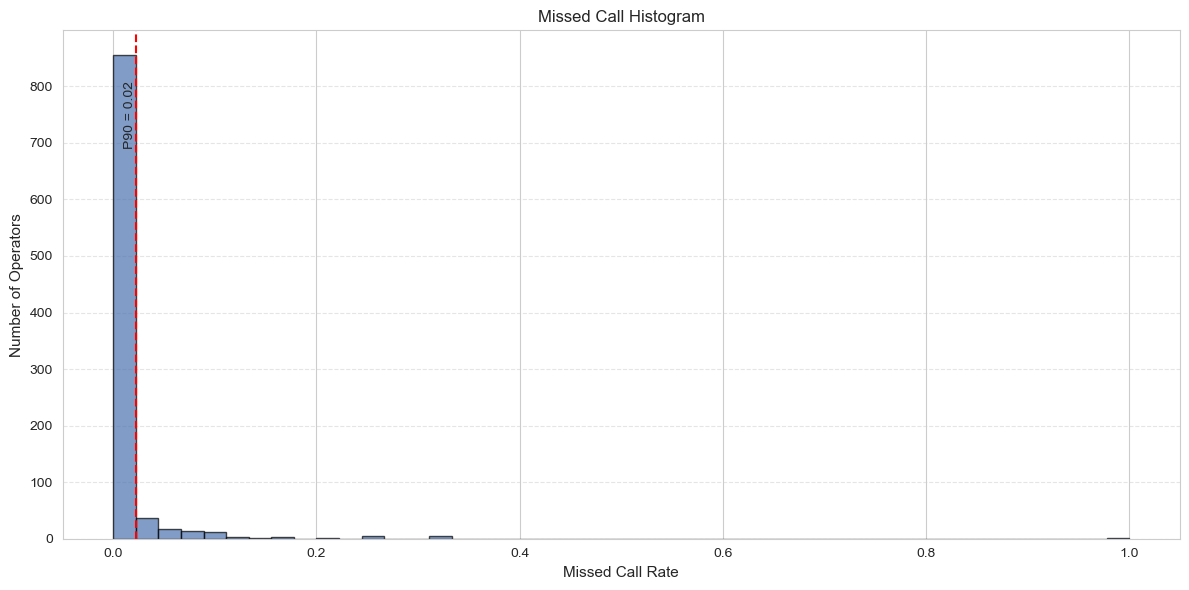

In [31]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(operator_stats['missed_in_rate'], bins=45, edgecolor='black', alpha=0.7, color='#4C72B0')

#Línea de p90 y etiqueta directa
ax.axvline(p90_missed, color='red', linestyle='--', linewidth=1.5)
ax.text(p90_missed, ax.get_ylim()[1]*0.9, f'P90 = {p90_missed:.2f}', 
        rotation=90, va='top', ha='right', fontsize=10)


ax.set_xlabel('Missed Call Rate', fontsize=11)
ax.set_ylabel('Number of Operators', fontsize=11)
ax.set_title('Missed Call Histogram', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


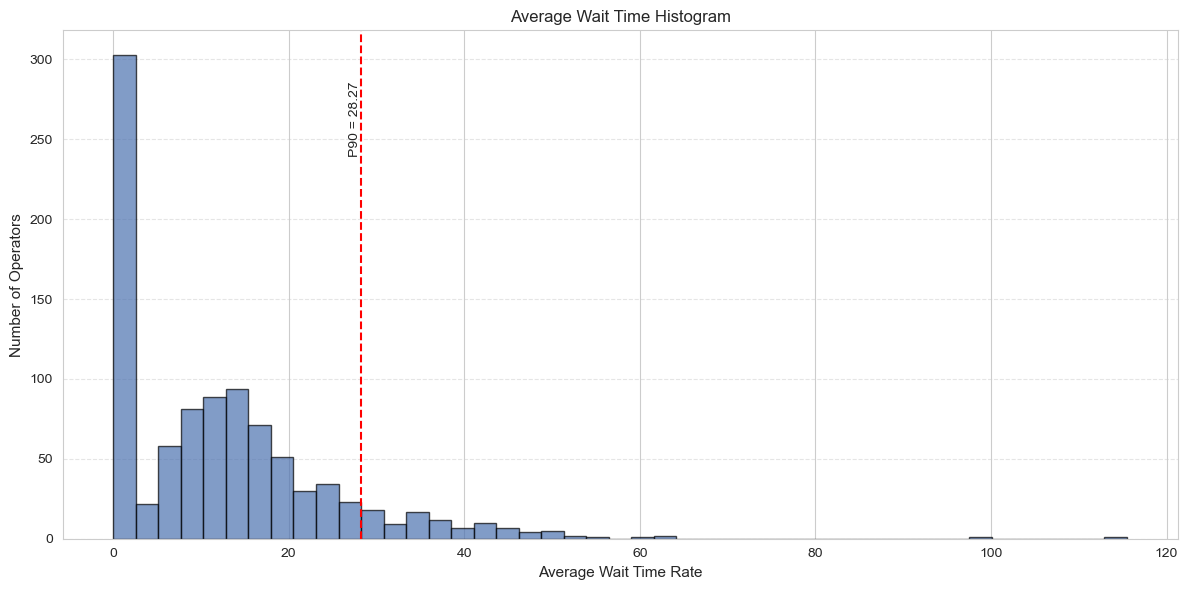

In [32]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(operator_stats['avg_wait_time'], bins=45, edgecolor='black', alpha=0.7, color='#4C72B0')

#Línea de p90 y etiqueta directa
ax.axvline(p90_wait, color='red', linestyle='--', linewidth=1.5)
ax.text(p90_wait, ax.get_ylim()[1]*0.9, f'P90 = {p90_wait:.2f}', 
        rotation=90, va='top', ha='right', fontsize=10)


ax.set_xlabel('Average Wait Time Rate', fontsize=11)
ax.set_ylabel('Number of Operators', fontsize=11)
ax.set_title('Average Wait Time Histogram', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

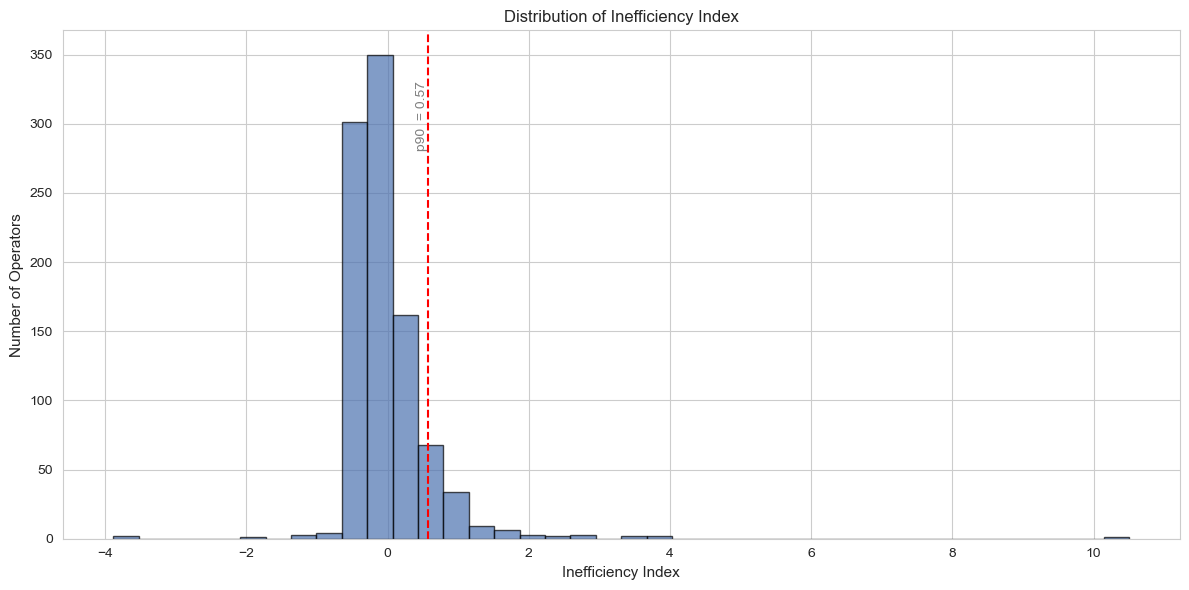

In [33]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# Histograma limpio
ax.hist(
    operator_stats['inef_index'],
    bins=40,
    edgecolor='black',
    alpha=0.7, 
    color='#4C72B0'
)

# Línea de p90 
ax.axvline(p90_index, linestyle='--', linewidth=1.5, color='red')
ax.text(
    p90_index,                 
    ax.get_ylim()[1]*0.9,      
    f'p90  = {p90_index:.2f}',  
    rotation=90,
    va='top',
    ha='right',
    fontsize=10,
    color='gray'
)


ax.set_xlabel('Inefficiency Index', fontsize=11)
ax.set_ylabel('Number of Operators', fontsize=11)
ax.set_title('Distribution of Inefficiency Index', fontsize=12)
plt.tight_layout()


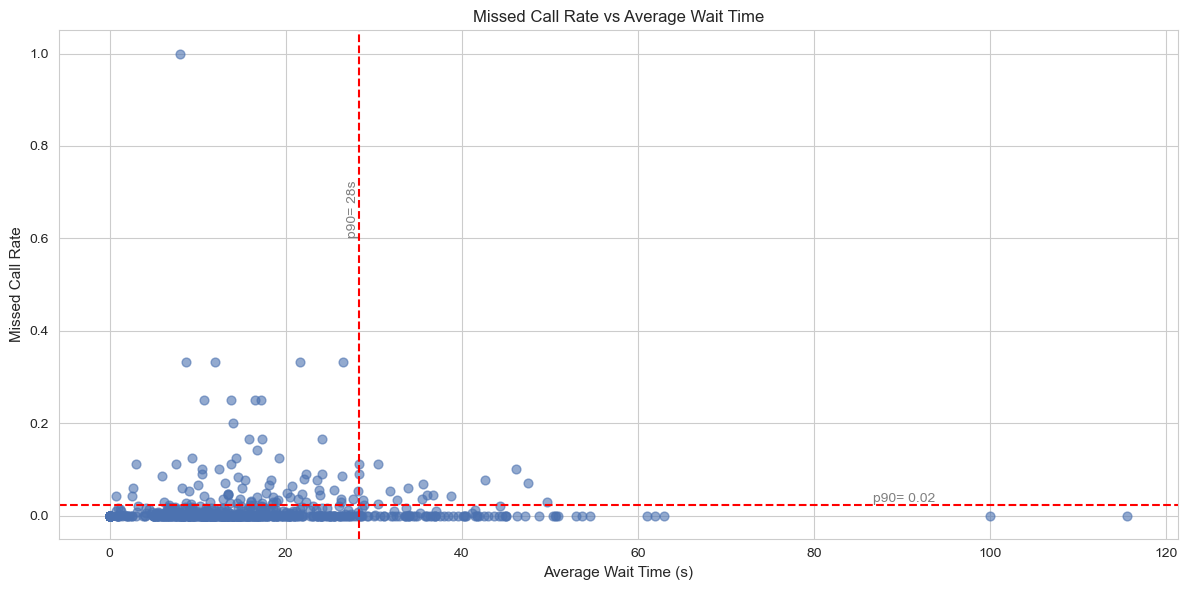

In [34]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    operator_stats['avg_wait_time'],
    operator_stats['missed_in_rate'],
    alpha=0.6,
    s=40, 
    color='#4C72B0'
)

ax.axhline(p90_missed, linestyle='--', linewidth=1.5, color='red')
ax.text(
    ax.get_xlim()[0]*-15, p90_missed, 
    f'p90= {p90_missed:.2f}', 
    va='bottom', ha='left', fontsize=10, color='gray'
)

ax.axvline(p90_wait, linestyle='--', linewidth=1.5, color='red')
ax.text(
    p90_wait, ax.get_ylim()[0]*-12, 
    f'p90= {p90_wait:.0f}s', 
    va='bottom', ha='right', rotation=90, fontsize=10, color='gray'
)


ax.set_xlabel('Average Wait Time (s)', fontsize=11)
ax.set_ylabel('Missed Call Rate', fontsize=11)
ax.set_title('Missed Call Rate vs Average Wait Time', fontsize=12)

plt.tight_layout()
plt.show()

### Analyze by plan type

In [35]:
df_plan['in_call']   = np.where(df_plan['direction']=='in', df_plan['calls_count'], 0)
df_plan['out_call']  = np.where(df_plan['direction']=='out', df_plan['calls_count'], 0)
df_plan['missed_in'] = np.where(
    (df_plan['direction'] == 'in') & (df_plan['is_missed_call']),
    1, 0
)

df_plan['in_total_duration'] = np.where(
    df_plan['direction'] == 'in',
    df_plan['total_call_duration'],
    0
)
df_plan['in_calls_count'] = np.where(
    df_plan['direction'] == 'in',
    df_plan['calls_count'],
    0
)

df_plan['wait_time'] = np.where(
    df_plan['direction'] == 'in',
    df_plan['total_call_duration'] - df_plan['call_duration'],
    0
)
df_plan = df_plan[df_plan['wait_time'] >= 0]

df_ops_plan = df_plan[df_plan['operator_id'] != -1]

operator_stats_plan = (
    df_ops_plan
    .groupby(['tariff_plan', 'operator_id'])
    .agg(
        total_calls        = ('calls_count',       'sum'),
        total_in_calls     = ('in_call',           'sum'),
        total_out_calls    = ('out_call',          'sum'),
        missed_in_calls    = ('missed_in',         'sum'),
        total_in_duration  = ('in_total_duration', 'sum'),
        total_wait_time    = ('wait_time',         'sum')
    )
)


operator_stats_plan['avg_in_duration'] = (
    operator_stats_plan['total_in_duration'] / operator_stats_plan['total_in_calls']
).replace([np.inf, np.nan], 0)

operator_stats_plan['missed_in_rate'] = (
    operator_stats_plan['missed_in_calls'] / operator_stats_plan['total_in_calls']
).fillna(0)

operator_stats_plan['avg_wait_time'] = (
    operator_stats_plan['total_wait_time'] / operator_stats_plan['total_in_calls']
).replace([np.inf, np.nan], 0)
operator_stats_plan = operator_stats_plan.reset_index()
operator_stats_plan = operator_stats_plan[operator_stats_plan['total_calls'] > 3 ]

display(operator_stats_plan)

,tariff_plan,operator_id,total_calls,total_in_calls,total_out_calls,missed_in_calls,total_in_duration,total_wait_time,avg_in_duration,missed_in_rate,avg_wait_time
1,A,885876,59429,992,58437,17,68239,9017,68.789315,0.017137,9.089718
2,A,885890,60221,1244,58977,21,90793,11306,72.984727,0.016881,9.088424
3,A,886146,50,1,49,0,1808,9,1808.000000,0.000000,9.000000
4,A,887992,47,0,47,0,0,0,0.000000,0.000000,0.000000
5,A,888532,200,12,188,2,2639,289,219.916667,0.166667,24.083333
...,...,...,...,...,...,...,...,...,...,...,...
1085,C,969380,8,1,7,0,121,21,121.000000,0.000000,21.000000
1086,C,969386,54,0,54,0,0,0,0.000000,0.000000,0.000000
1087,C,969600,19,0,19,0,0,0,0.000000,0.000000,0.000000
1089,C,971102,76,76,0,0,11964,1352,157.421053,0.000000,17.789474


/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_82065/2263836995.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tariff_plan', y='total_out_calls', data=operator_stats_plan, palette='Blues')


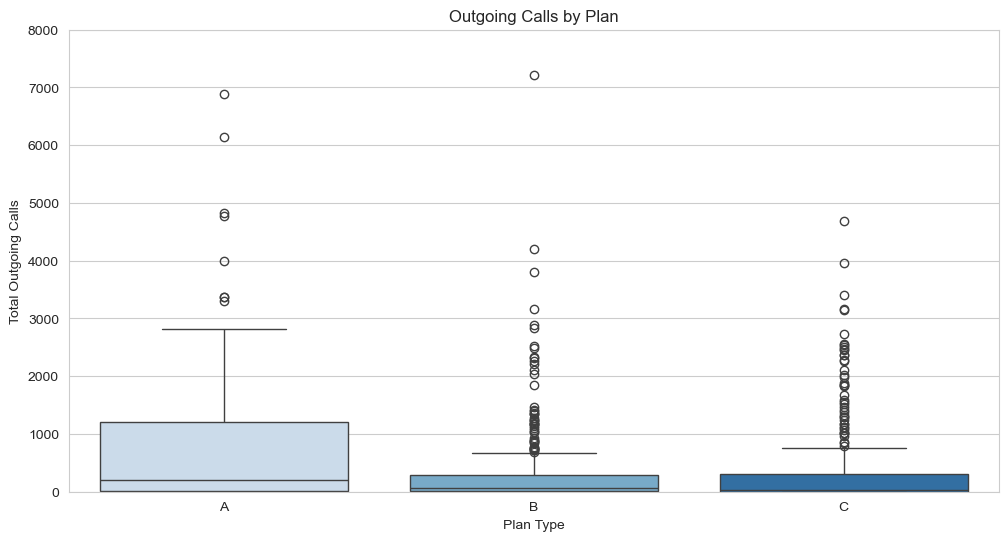

In [36]:
# Boxplot of outgoing calls by tariff plan
plt.figure(figsize=(12,6))
plt.ylim(0,8000)
sns.boxplot(x='tariff_plan', y='total_out_calls', data=operator_stats_plan, palette='Blues')
plt.title('Outgoing Calls by Plan')
plt.xlabel('Plan Type')
plt.ylabel('Total Outgoing Calls')
plt.show()


/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_82065/4177377209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tariff_plan', y='missed_in_rate', data=operator_stats_plan, palette='Blues')


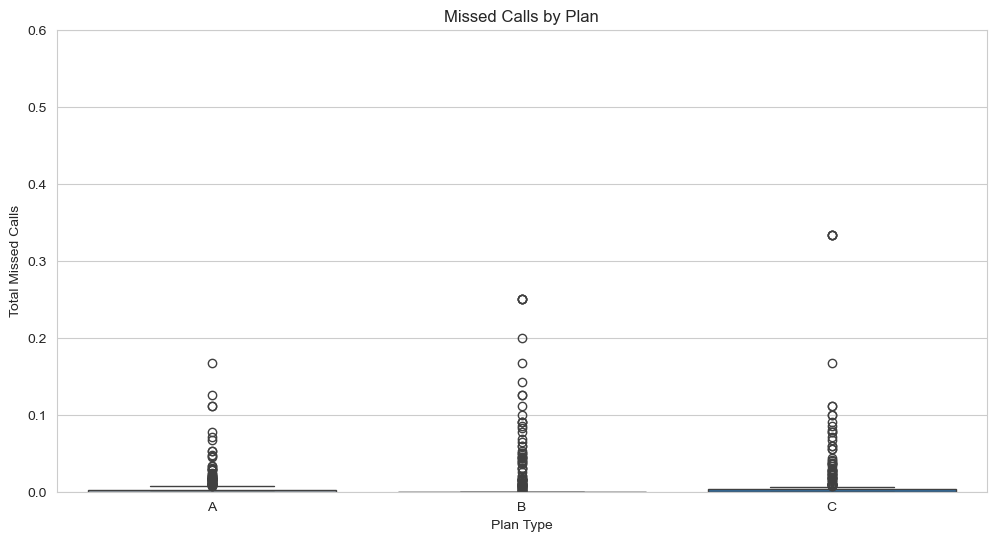

In [37]:
# Boxplot de llamadas salientes
plt.figure(figsize=(12,6))
plt.ylim(0,.6)
sns.boxplot(x='tariff_plan', y='missed_in_rate', data=operator_stats_plan, palette='Blues')
plt.title('Missed Calls by Plan')
plt.xlabel('Plan Type')
plt.ylabel('Total Missed Calls')
plt.show()

/var/folders/j_/7ll1w8n13nq1q1p7bf8pyjj00000gn/T/ipykernel_82065/1760095469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tariff_plan', y='avg_wait_time', data=operator_stats_plan, palette='Blues')


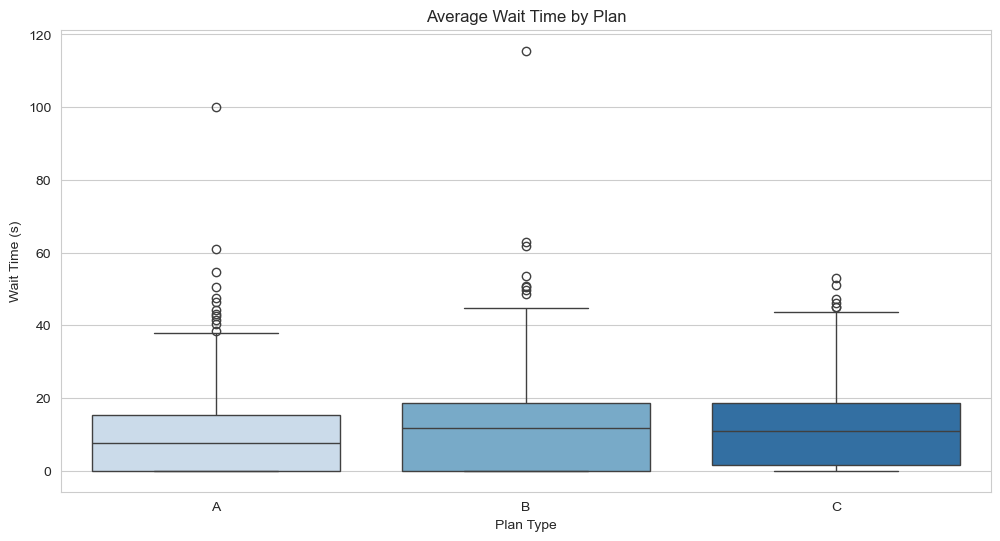

In [38]:
plt.figure(figsize=(12,6))
#plt.ylim(0,.6)
sns.boxplot(x='tariff_plan', y='avg_wait_time', data=operator_stats_plan, palette='Blues')
plt.title('Average Wait Time by Plan')
plt.xlabel('Plan Type')
plt.ylabel('Wait Time (s)')
plt.show()

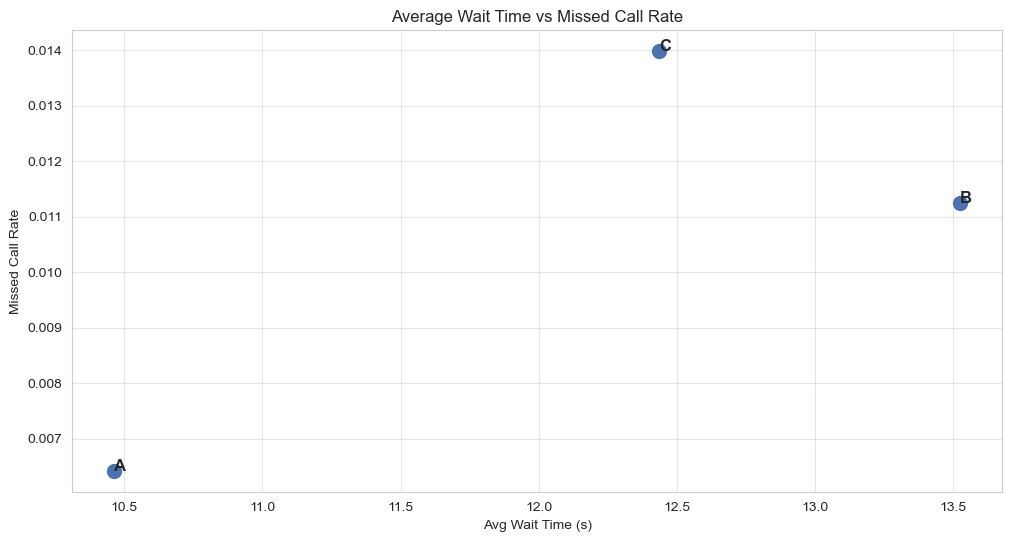

In [39]:
df_plan = (
    operator_stats_plan
    .groupby('tariff_plan')[['avg_wait_time','missed_in_rate']]
    .mean()
)

plt.figure(figsize=(12,6))
plt.scatter(df_plan['avg_wait_time'], df_plan['missed_in_rate'], s=100, color='#4C72B0')

for plan in df_plan.index:
    x = df_plan.loc[plan, 'avg_wait_time']
    y = df_plan.loc[plan, 'missed_in_rate']
    plt.annotate(plan, (x, y), fontsize=12, fontweight='bold')

# 4) Ajusta etiquetas y título
plt.title('Average Wait Time vs Missed Call Rate')
plt.xlabel('Avg Wait Time (s)')
plt.ylabel('Missed Call Rate')
plt.grid(True, alpha=0.5)
plt.show()

In [40]:
summary = operator_stats_plan.groupby('tariff_plan')[['total_out_calls', 'missed_in_rate', 'avg_wait_time']].agg(['mean', 'median'])
display(summary)

total_out_calls        missed_in_rate        avg_wait_time  \
                       mean median           mean median          mean   
tariff_plan                                                              
A               1235.613475  194.5       0.006413    0.0     10.464380   
B                327.741840   62.0       0.011255    0.0     13.524057   
C                447.134731   28.0       0.013983    0.0     12.435468   

                        
                median  
tariff_plan             
A             7.538647  
B            11.825175  
C            10.939676

Since the rate of dropped calls has more weight, Plan C is the least efficient.


## 5. Statistical Hypothesis Testing

To formulate hypothesis tests, we will follow this approach:
<ul>
<li>Null hypothesis (H0): There is no significant difference between the groups </li>
<li>Alternative hypothesis (H1): There is a significant difference </li>
<li>Significance level: α = 0.05 </li>
</ul>

For **avg_wait_time** (Average Wait Time) <br>
H0: μ_avg_wait_time_inefficient = μ_avg_wait_time_efficient <br>
H1: μ_avg_wait_time_inefficient ≠ μ_avg_wait_time_efficient <br>

For **missed_in_rate** (Missed Call Rate) <br>
H0: μ_missed_in_rate_inefficient = μ_missed_in_rate_efficient <br>
H1: μ_missed_in_rate_inefficient ≠ μ_missed_in_rate_efficient <br>

For **total_out_calls** (Total Outgoing Calls) <br>
H0: μ_total_out_calls_inefficient = μ_total_out_efficient_calls <br>
H1: μ_total_out_inefficient_calls ≠ μ_total_out_efficient_calls <br>

Divide data in efficients and inefficients operatros

In [41]:
inefficient = operator_stats[operator_stats['ineffective'] == True]
efficient = operator_stats[operator_stats['ineffective'] == False]

In [42]:
#Prueba para avg_wait_time
t_stat_wait, p_value_wait = stats.ttest_ind(
    inefficient['avg_wait_time'],
    efficient['avg_wait_time'],
    equal_var=False,  # Corrección de Welch
    nan_policy='omit'
)

#Prueba para missed_in_rate
t_stat_missed, p_value_missed = stats.ttest_ind(
    inefficient['missed_in_rate'],
    efficient['missed_in_rate'],
    equal_var=False,
    nan_policy='omit'
)

# Prueba para total_out_calls
t_stat_out, p_value_out = stats.ttest_ind(
    inefficient['total_out_calls'],
    efficient['total_out_calls'],
    equal_var=False,
    nan_policy='omit'
)

alpha = 0.05

print("Results for avg_wait_time:")
print(f"t-statistic = {t_stat_wait:.4f}, p-value = {p_value_wait:.23f}")
print(f"Conclusion: {'Reject H0. Inefficient carriers have SIGNIFICANTLY higher wait times' if p_value_wait < alpha else 'Do not reject H0'}")

print("\nResults for missed_in_rate:")
print(f"t-statistic = {t_stat_missed:.4f}, p-value = {p_value_missed:.10f}")

print(f"Conclusion: {'Reject H0. Inefficient carriers have SIGNIFICANTLY higher missed call rates' if p_value_missed < alpha else 'Do not reject H0'}")

print("\nResults for total_out_calls:")
print(f"t-statistic = {t_stat_out:.4f}, p-value = {p_value_out:.10f}")
print(f"Conclusion: {'Reject H0. Inefficient carriers make SIGNIFICANTLY fewer outbound calls' if p_value_out < alpha else 'Do not reject H0'}")

Results for avg_wait_time:
t-statistic = 11.3959, p-value = 0.00000000000000000007811
Conclusion: Reject H0. Inefficient carriers have SIGNIFICANTLY higher wait times

Results for missed_in_rate:
t-statistic = 6.0633, p-value = 0.0000000268
Conclusion: Reject H0. Inefficient carriers have SIGNIFICANTLY higher missed call rates

Results for total_out_calls:
t-statistic = -5.0410, p-value = 0.0000005545
Conclusion: Reject H0. Inefficient carriers make SIGNIFICANTLY fewer outbound calls


## 7. Conclusions

In summary, the statistical analysis conclusively demonstrates that the group of operators labeled "inefficient" performs substantially worse than their efficient peers: their average wait time is significantly higher, indicating systematic delays in service; their rate of inbound call losses is also notably higher, reflecting a lower capacity to respond in a timely manner; and, additionally, they execute significantly fewer outbound calls, suggesting a lack of proactivity in contact management.

These findings validate the classification criteria used and underscore the need for targeted interventions (e.g., training in time management and call protocols) to increase the efficiency of the identified group, optimize the customer experience, and balance the workload among all operators.